In [ ]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:

!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.5.0.html
!pip install torch-geometric


In [3]:
from torch.autograd import Variable
import torch_geometric.transforms
from torch_geometric.transforms import knn_graph
import torch_geometric.data
import torch 
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import torch
import pyarrow as pa
import pyarrow.parquet as pq
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.nn import knn_graph
import os 

from torch.utils.data import *
from functools import partial
import timeit

In [4]:
import argparse
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=50, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=16, help='Initial learning rate.') #100

parser.add_argument('--lr', type=float, default=0.001, help='Initial learning rate.') #0.001
parser.add_argument('--dropout', type=float, default=0.3, help='Dropout rate (1 - keep probability).')
args = parser.parse_args([])
torch.backends.cudnn.benchmark = True

In [5]:
class ParquetDataset(Dataset):
    def __init__(self, filename):
        self.parquet = pq.ParquetFile(filename)
        self.cols = None 
    def __getitem__(self, index):
        data = self.parquet.read_row_group(index, columns=self.cols).to_pydict()
        data['X_jets'] = np.float32(data['X_jets'][0]) 
        # Preprocessing
        data['X_jets'] = data['X_jets'][1]
        data['X_jets'][data['X_jets'] < 1.e-3] = 0. # Zero-Suppression
        return dict(data)
    def __len__(self):
        return self.parquet.num_row_groups

In [6]:
def jets(i, ecal):
    xhit2,yhit2 = torch.nonzero(ecal[i])[:, 0].cpu().numpy(), torch.nonzero(ecal[i])[:, 1].cpu().numpy()    
    eneEcal=ecal[i].cpu().numpy()[xhit2,yhit2]
    feats=np.transpose(np.vstack((xhit2,yhit2,eneEcal)))  ## concatenate x,y locations and energies (3 features in total)
    cords=feats[:,[0,1]] ## cords = x,y coordinates 
    allFeats=torch.from_numpy(feats).float()  ## features to tensors 
    cords2=torch.from_numpy(cords)  ## coordinates to tensors 
    edge_index = knn_graph(cords2, k=4, batch=None, loop=True)  ## Create knn graph adjacency matrix 
    data=Data(x=allFeats,edge_index=edge_index) ## Create graph data with feature matrix x and adjacency matrix edge_index
    return data

In [7]:
def get_data_loader(datasets, batch_size, cut, random_sampler=False):
    dset = ConcatDataset([ParquetDataset(dataset) for dataset in datasets])
    idxs = np.random.permutation(len(dset))
    if random_sampler: 
        random_sampler = sampler.SubsetRandomSampler(idxs[:cut])
    else: 
        random_sampler = None 
    data_loader = DataLoader(dataset=dset, batch_size=batch_size, shuffle=False, num_workers=10, sampler=random_sampler, pin_memory=True)
    return data_loader

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
cd drive/My\ Drive/parquets

/content/drive/My Drive/parquets


In [10]:
datasets = ['Boosted_Jets_Sample-%i.snappy.parquet'%i for i in range(1)]
data_loader = get_data_loader(datasets, args.batch_size, cut = None, random_sampler = True)

In [11]:
def jets(datei,number1,number2):

    cols = None
    graphs=[]

    for i in range(number1,number2):
      #datei['X_jets'] = np.float32(datei['X_jets']) [0] 
      
      #ecal=datei['X_jets'][1]  ## Select ECAL Data out of the 3 available channels

      #ecal[ecal<=1e-3]=0  ## Remove noisy values
      
      ecal=datei[i].cpu().numpy()

      xhit2,yhit2=np.nonzero(ecal)  ## Select hits in detector

      eneEcal=ecal[xhit2,yhit2]  ## Select energies of hits

      feats=np.transpose(np.vstack((xhit2,yhit2,eneEcal)))  ## concatenate x,y locations and energies (3 features in total)
      
      cords=feats[:,[0,1]] ## cords = x,y coordinates 
      
      allFeats=torch.from_numpy(feats).float()  ## features to tensors 
      
      cords2=torch.from_numpy(cords)  ## coordinates to tensors 
    
      edge_index = knn_graph(cords2, k=6, batch=None, loop=True)  ## Create knn graph adjacency matrix 

      donnees=Data(x=allFeats,edge_index=edge_index) ## Create graph data with feature matrix x and adjacency matrix edge_index
      
      graphs.append(donnees)

    return graphs


In [12]:
import torch_geometric.transforms
from torch_geometric.nn import knn_graph
import torch_geometric.data
import torch 
from torch_geometric.data import Data
import numpy as np
def torchjets(datei,number1,number2):

    cols = None

    graphs=[]

    for i in range(number1,number2):

      ecal=datei[i]

      xhit2,yhit2=torch.nonzero(ecal,as_tuple=True)  ## Select hits in detector

      eneEcal=-torch.log(ecal[xhit2,yhit2]) ## Select energies of hits

      feats=torch.stack((xhit2.float(),yhit2.float(),eneEcal),dim=1) ## concatenate x,y locations and energies (3 features in total)

      cords=feats[:,[0,1]].cuda() ## cords = x,y coordinates 


      edge_index = knn_graph(cords[:2000], k=6, batch=None, loop=True,num_workers=10)  ## Create knn graph adjacency matrix 

      donnees=Data(x=feats[:2000],edge_index=edge_index) ## Create graph data with feature matrix x and adjacency matrix edge_index
      
      graphs.append(donnees)

    return graphs

In [13]:
cd ../v22/Version2_Pooling

/content/drive/My Drive/v22/Version2_Pooling


In [14]:
import VAE#DiffAE

In [15]:
model3=VAE.GraphAE(3,16,32,64,128,256,512, 0.3)#DiffAE.GraphAE()
model3.train()
model3.to(device)#.cuda()

GraphAE(
  (sage1): DenseGCNConv(3, 16)
  (sage2): DenseGCNConv(16, 32)
  (poolit1): DenseGCNConv(32, 500)
  (poolit2): DenseGCNConv(128, 250)
  (poolit3): DenseGCNConv(256, 10)
  (sage3): DenseGCNConv(32, 64)
  (sage4): DenseGCNConv(64, 128)
  (sage5): DenseGCNConv(128, 256)
  (tr1): Linear(in_features=256, out_features=512, bias=True)
  (tr2): Linear(in_features=512, out_features=2048, bias=True)
  (rev1): Linear(in_features=512, out_features=256, bias=True)
  (rev2): Linear(in_features=2048, out_features=512, bias=True)
  (revsage1): DenseGCNConv(16, 3)
  (revsage2): DenseGCNConv(32, 16)
  (revsage3): DenseGCNConv(64, 32)
  (revsage4): DenseGCNConv(128, 64)
  (revsage5): DenseGCNConv(256, 128)
  (drop): Dropout(p=0.2, inplace=False)
  (bano1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, tr

In [18]:

checkpoint = torch.load('loadBatches_b16_pool3.pth')
model3.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
model3.eval()
model3.to(device)


GraphAE(
  (sage1): DenseGCNConv(3, 16)
  (sage2): DenseGCNConv(16, 32)
  (poolit1): DenseGCNConv(32, 500)
  (poolit2): DenseGCNConv(128, 250)
  (poolit3): DenseGCNConv(256, 10)
  (sage3): DenseGCNConv(32, 64)
  (sage4): DenseGCNConv(64, 128)
  (sage5): DenseGCNConv(128, 256)
  (tr1): Linear(in_features=256, out_features=512, bias=True)
  (tr2): Linear(in_features=512, out_features=2048, bias=True)
  (rev1): Linear(in_features=512, out_features=256, bias=True)
  (rev2): Linear(in_features=2048, out_features=512, bias=True)
  (revsage1): DenseGCNConv(16, 3)
  (revsage2): DenseGCNConv(32, 16)
  (revsage3): DenseGCNConv(64, 32)
  (revsage4): DenseGCNConv(128, 64)
  (revsage5): DenseGCNConv(256, 128)
  (drop): Dropout(p=0.2, inplace=False)
  (bano1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bano3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
scaler = torch.cuda.amp.GradScaler() 

In [17]:
optimizer = torch.optim.Adam(model3.parameters(), lr=args.lr, weight_decay=0.0001)

In [19]:

## generate list to count nodes for each graph
def nodeCounter(samples):
    inds=[]
    for k in samples:
        inds.append(k['x'].shape[0])
    return inds

In [20]:
def ref(bsize,nodeC,i1,i2):
  maxC=np.max(np.array(nodeC))
  maxC=2000#maxC + (4 - maxC % 4) ##max num of nodes 1161%4
  refMat=np.zeros((bsize,maxC)) ## matrix of zeros
  for pi in range(i1,i2):##10
    refMat[bsize-(i2-pi),:nodeC[pi]]=1 ## fill ones 
  return refMat,maxC

In [21]:
def assigner(nodelist):
  fin=[]
  countit=0
  for m in nodelist:
      fin.append(np.repeat(countit,m))
      countit+=1
  return np.array(fin)

In [22]:
from optimizer import loss_function

In [ ]:
#from torch.cuda.amp import GradScaler, autocast

In [ ]:
import time
for epoch in range(50):
      #model.train()
  count=0
  c1,c2=0,args.batch_size
  epLoss=0
  t = time.time()
  for i, data in enumerate(data_loader):
        ecal2 = data['X_jets'].cuda()
        rawGraph=torchjets(ecal2,0,args.batch_size) ##Generating graphs from raw data 
        nodeCount=nodeCounter(rawGraph)
        lengs=torch.LongTensor(np.hstack(assigner(np.array(nodeCount[c1:c2])-c1))).cuda()
        
        compress=torch_geometric.data.Batch.from_data_list(rawGraph)

        gra=compress.x.to(device)
        adj=compress.edge_index.to(device)

        count+=1
        refMat,maxCount=ref(args.batch_size,nodeCount,c1,c2)
        
        optimizer.zero_grad()
        mask=torch.from_numpy(refMat).to(device) 
        #maxi=torch.from_numpy(np.array(maxCount)).to(device)

        r1 ,adj1,mu,sig= model3(gra,adj,lengs.to(device),mask,2000)

        #sparse=to_sparse_batch(r1, adj1, mask=torch.LongTensor(mask).cuda())

        loss = loss_function(r1,gra,nodeCount,lengs,2000,mu,sig)/args.batch_size    


        """
        with torch.cuda.amp.autocast(): 
            loss = loss_function(r1,gra,lengs,refMat,mu,sig)  
      
        # Scales the loss, and calls backward() 
        # to create scaled gradients 
        scaler.scale(loss).backward() 
      
        # Unscales gradients and calls 
        # or skips optimizer.step() 
        scaler.step(optimizer) 
      
        # Updates the scale for next iteration 
        scaler.update() 
        """    

        loss.backward()

        optimizer.step()

        cur_loss = loss.item()
        
        epLoss+=float(cur_loss)

        #c1+=args.batch_size
        #c2+=args.batch_size
        if count%900==0:
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(epLoss/count),"time=", "{:.5f}".format(time.time() - t))
            t = time.time()

  torch.save({
        'epoch': epoch,
        'model_state_dict': model3.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch':epoch,
        'loss': loss,
        'epLoss':epLoss
        }, './loadBatches_b16_pool3.pth')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0001 train_loss= 178.40236 time= 628.34234
Epoch: 0001 train_loss= 175.36497 time= 609.10003
Epoch: 0002 train_loss= 164.91543 time= 606.91102
Epoch: 0002 train_loss= 162.14219 time= 599.15306
Epoch: 0003 train_loss= 152.75018 time= 599.48428
Epoch: 0003 train_loss= 150.35433 time= 590.94368
Epoch: 0004 train_loss= 142.42210 time= 589.28247
Epoch: 0004 train_loss= 140.26258 time= 585.04688
Epoch: 0005 train_loss= 132.24339 time= 588.48629
Epoch: 0005 train_loss= 130.77431 time= 587.11707
Epoch: 0006 train_loss= 124.07894 time= 591.41087
Epoch: 0006 train_loss= 122.29631 time= 585.83221
Epoch: 0007 train_loss= 116.23299 time= 589.74628
Epoch: 0007 train_loss= 114.59743 time= 586.92941
Epoch: 0008 train_loss= 109.34608 time= 597.12317
Epoch: 0008 train_loss= 108.46691 time= 592.66279
Epoch: 0009 train_loss= 103.56319 time= 600.57214
Epoch: 0009 train_loss= 102.59205 time= 596.65919
Epoch: 0010 train_loss= 98.60540 time= 601.21698
Epoch: 0010 train_loss= 97.72580 time= 596.37192
Ep

In [ ]:
x2,_,_=to_sparse_batch(r1, adj1, torch.LongTensor(refMat).cuda())

In [ ]:
adj1.shape

In [ ]:
r1[:,nodeCount,:].shape

In [ ]:
lossMSE=torch.nn.MSELoss()
lossMSE(x2,gra)

In [23]:
testsets = ['../../parquets/Boosted_Jets_Sample-%i.snappy.parquet'%i for i in range(2,3)]
testloader = get_data_loader(testsets, args.batch_size, cut = None, random_sampler = True)

In [ ]:
pwd

In [24]:
import time
for epoch in range(1):
      #model.train()
  count=0
  c1,c2=0,args.batch_size
  epLoss=0
  t = time.time()
  model3.eval()
  with torch.no_grad():
    for i, data in enumerate(testloader):
          ecal2 = data['X_jets'].cuda()
          rawGraph=torchjets(ecal2,0,args.batch_size) ##Generating graphs from raw data 
          nodeCount=nodeCounter(rawGraph)
          lengs=torch.LongTensor(np.hstack(assigner(np.array(nodeCount[c1:c2])-c1))).cuda()
          
          compress=torch_geometric.data.Batch.from_data_list(rawGraph)

          gra=compress.x.to(device)
          adj=compress.edge_index.to(device)

          count+=1
          refMat,maxCount=ref(args.batch_size,nodeCount,c1,c2)
          
          mask=torch.from_numpy(refMat).to(device)
          #maxi=torch.from_numpy(np.array(maxCount)).to(device)

          r1 ,adj1,mu,sig= model3(gra,adj,lengs.to(device),mask,2000)

          loss = loss_function(r1,gra,nodeCount,lengs,2000,mu,sig)/args.batch_size

          cur_loss = loss.item()
          
          epLoss+=float(cur_loss)


          #c1+=args.batch_size
          #c2+=args.batch_size
          if count%20==0:
              print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(epLoss/count),"time=", "{:.5f}".format(time.time() - t))
              t = time.time()
              break;

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0001 train_loss= 84.03248 time= 27.37847


In [25]:
r1.shape


torch.Size([16, 2000, 3])

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm

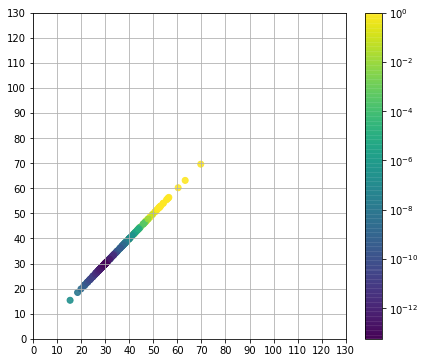

In [29]:
%matplotlib inline
#xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
#ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
r12=r1[0].cpu().clone()
xmin,xmax=0,125
ymin,ymax=0,125
binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
weights=np.exp(-r12[:300,2])
plt.figure(figsize=(7,6))
sc = plt.scatter(r12[:300,0],r12[:300,1],c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)
plt.colorbar(sc)
check=np.arange(0,140,10)
plt.xticks(check)
plt.yticks(check)
plt.grid()


In [28]:
gra

tensor([[  1.0000,  34.0000,   3.6149],
        [  1.0000,  35.0000,   3.6149],
        [  2.0000,  34.0000,   3.6149],
        ...,
        [118.0000,  11.0000,   2.9602],
        [121.0000,   1.0000,   3.6322],
        [124.0000,  37.0000,   3.8149]], device='cuda:0')

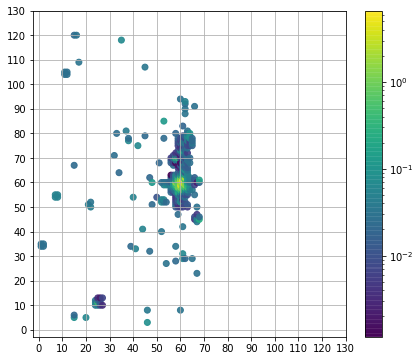

In [32]:
%matplotlib inline
r12=gra.cpu().clone()
xmin,xmax=0,125
ymin,ymax=0,125
binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
weights=np.exp(-r12[:300,2])
plt.figure(figsize=(7,6))
sc = plt.scatter(r12[:300,0],r12[:300,1],c=weights,cmap='viridis', norm=LogNorm(),alpha=0.9)
plt.colorbar(sc)
check=np.arange(0,140,10)
plt.xticks(check)
plt.yticks(check)
plt.grid()
